# Receiving and demodulating FM signals using RTL-SDR & Pynq-Z2

In this notebook, we will use AD9361 to receive a real-world FM signal and demodulate it.

Before using the rtlsdr library, follow https://github.com/librtlsdr/librtlsdr to install librtlsdr and https://github.com/pyrtlsdr/pyrtlsdr to install pyrtlsdr on your Pynq-Z2 board.

## 1. Receiving FM samples

In [2]:
from rtlsdr import RtlSdr
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('dark_background')

sdr = RtlSdr()

c:\Users\jhosg\Documents\Trabajo\GCPDS\PROYECTO ANE MINISTERIO\CODIGO EN PYTHON\.venv\Lib\site-packages\rtlsdr\rtlsdr.py:87: SyntaxWarning: invalid escape sequence '\_'
  """Retrieves the device index for a device matching the given serial number


LibUSBError: <LIBUSB_ERROR_ACCESS (-3): Access denied (insufficient permissions)> "Could not open SDR (device index = 0)"

Then, we set the sample rate to 2.4M and receive one second of samples.

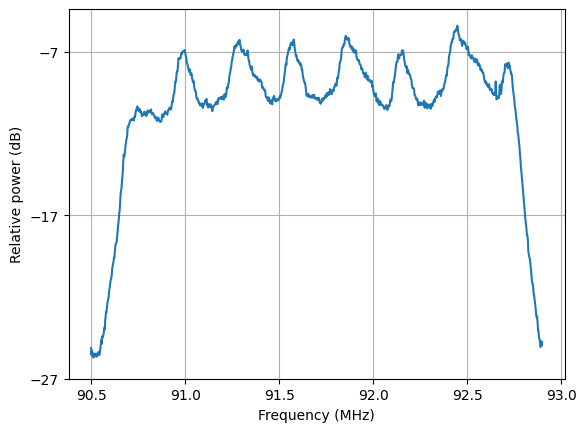

In [3]:
# 1) set down some important global variables
fc = 91_700_000    # center frequency
fs = 2_400_000    # sample rate
ns = 2400000  # number of samples

# 2) configure the relevant properties of rtlsdr.

sdr.sample_rate = fs  # Hz
sdr.center_freq = fc  # Hz
sdr.gain = 'auto'

# 3) receive to buffer
samples = sdr.read_samples(fs)

# 4) analyze the frequency band
plt.psd(samples, NFFT=1024, Fs=fs/1e6, Fc=fc/1e6)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative power (dB)')

plt.show()

As shown above, there is a peak at around 92.7 MHz, which indicates there is an FM station running at that frequency. You can look for FM stations at your location either by using a portable FM radio receiver or tinkering with the center frequency in Jupyter notebook.

You can save the samples for future use.

In [4]:
np.save("samples_received", samples)

# 2. Demodulating the FM samples

Next let's define the functions we have already developed in the first notebook.

In [9]:
def downsample(x, M, p=0):  
    if not isinstance(M, int):
        raise TypeError("M must be an int")
    x = x[0:int(np.floor(len(x) / M)) * M]
    x = x.reshape((int(np.floor(len(x) / M)), M))
    y = x[:,p]
    return y

def fm_discrim(x):
    X = np.real(x)
    Y = np.imag(x)
    b = np.array([1, -1])
    dY = signal.lfilter(b, 1, Y)
    dX = signal.lfilter(b, 1, X)
    discriminated = (X * dY - Y * dX) / (X**2 + Y**2 + 1e-10)
    return discriminated

def fm_audio(samples, fs=2.4e6, fc=92.7e6, fc1=200e3, fc2=12e3, d1=10, d2=5, plot=False):
    lpf_b1 = signal.firwin(64, fc1/(float(fs)/2))
    lpf_b2 = signal.firwin(64, fc2/(float(fs)/d1/2))
    
    # 1st filtering
    samples_filtered_1 = signal.lfilter(lpf_b1, 1, samples)
    # 1st decimation
    samples_decimated_1 = downsample(samples_filtered_1, d1)
    # phase discrimination
    samples_discriminated = fm_discrim(samples_decimated_1)
    # 2nd filtering
    samples_filtered_2 = signal.lfilter(lpf_b2, 1, samples_discriminated)
    # 2nd decimation
    audio = downsample(samples_filtered_2, d2)
    
    if plot:
        fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2, 3, figsize=(15, 10))

        ax0.psd(samples, NFFT=1024, Fs=fs/1e6, Fc=fc/1e6)
        ax0.set_title("samples")
        ax0.set_xlabel('Frequency (MHz)')
        ax0.set_ylabel('Relative power (dB)')
        
        ax1.psd(samples_filtered_1, NFFT=1024, Fs=fs/1e6, Fc=fc/1e6)
        ax1.set_title("samples_filtered_1")
        ax1.set_xlabel('Frequency (MHz)')
        ax1.set_ylabel('Relative power (dB)')

        ax2.psd(samples_decimated_1, NFFT=1024, Fs=fs/d1/1e6, Fc=fc/1e6)
        ax2.title.set_text('samples_decimated_1')
        ax1.set_xlabel('Frequency (MHz)')
        ax1.set_ylabel('Relative power (dB)')

        ax3.psd(samples_discriminated, NFFT=1024, Fs=fs/d1, Fc=0)
        ax3.title.set_text('samples_discriminated')

        ax4.psd(samples_filtered_2, NFFT=1024, Fs=fs/d1, Fc=0)
        ax4.title.set_text('samples_filtered_2')
        
        ax5.psd(audio, NFFT=1024, Fs=fs/d1/d2, Fc=0)
        ax5.title.set_text('audio')

        plt.show()
        
        return audio, fig, (ax0, ax1, ax2, ax3, ax4, ax5)
    else:
        return audio

Finally, we can demodulate the received signals and enjoy listening!

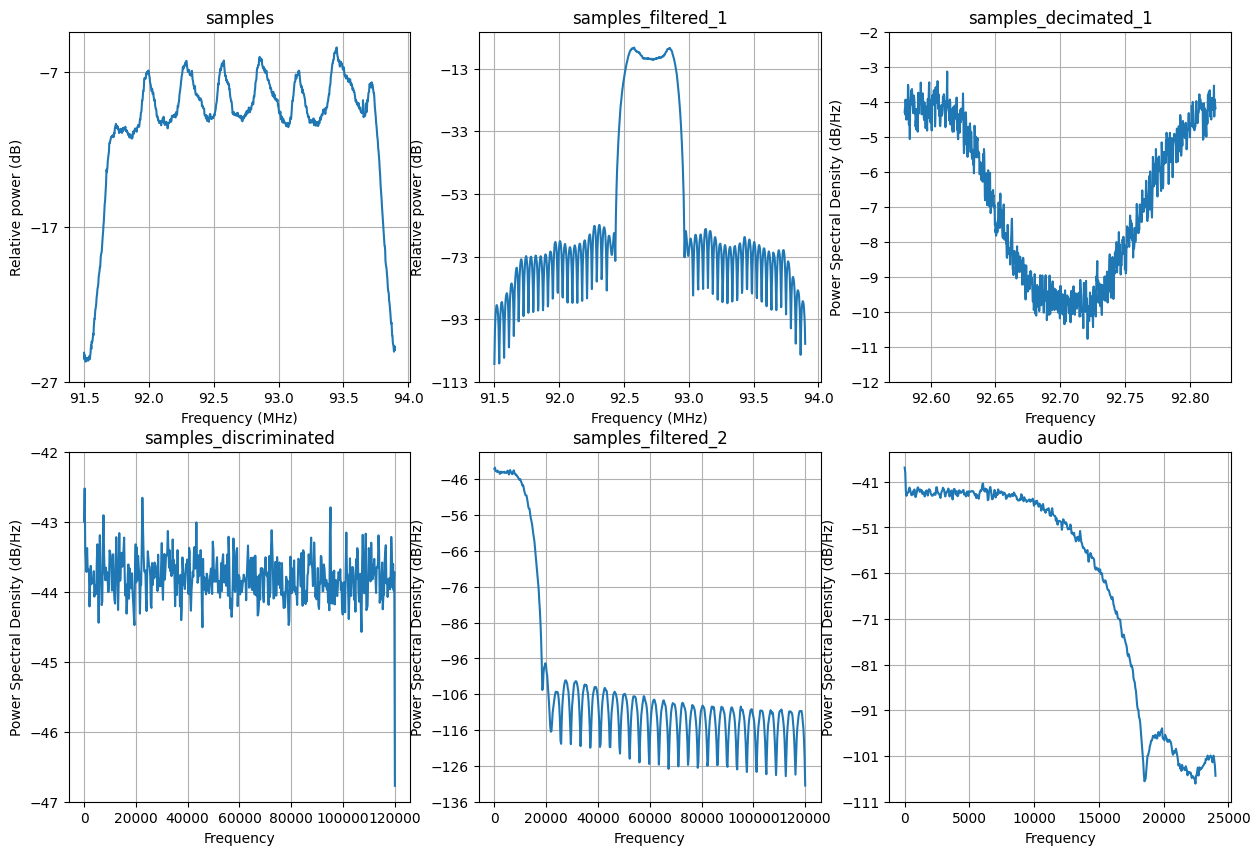

In [10]:
from IPython.display import Audio

audio, _, _ = fm_audio(samples, plot=True)
Audio(audio, rate=48000)

The quality of the output audio may depend on the size of your antenna, the location, and the surrounding environment.

# Conclusion

In this notebook, we used RTL-SDR to receive FM signals. Then, we demodulated the signals using the techniques developed in the previous notebook.

In the next notebook, we will deploy hardware demodulation using FPGAs, which is significantly faster compared to the software implementation.

# Reference

The main reference of this notebook is [Parallel Programming for FPGAs](https://pp4fpgas.readthedocs.io/en/latest/project7.html), which is developed by [Kastner Research Group](https://github.com/KastnerRG).